# Understanding the data and kinematic techniques

This notebook demonstrates the usage of the package over the simplified NA62 data format, using pandas dataframes. Kinematic techniques are used to perform kinematic selections. Through this you will understand how to use them and what powerful information they can provide. Through this we will also expose the meaning of some of the variables that are still mysterious  at this point.

The na62 python package provides convenience functions in several modules as a good starting point:
 - prepare.py: This module provides functionalities to read the data from root files and produce a pandas dataframe that can be used for the analysis
 - extract.py: This module provides functionalities to extract some parts of the dataframe to manipulate them more easily (e.g. track, clusters
 - hlf.py: This module provides functions high level to compute higher level information for the event (e.g. total momentum, invariant mass, total LKr energy, ...). This is mostly an implementation of the exercises of the previous notebook.
 - constants.py: This module provides some useful constants (particle masses, detector geometry, ...)
 - stats.py: This module provides more advanced statistical functions (fitting, ...)

# Understanding the data

In [1]:
# Lets first import all we need
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from na62 import prepare, hlf, extract, constants, stats

In [2]:
# Then we read the data. This will give us a dataframe which contains the data from all the root files we provided
data, _ = prepare.import_root_files(["data/run12450.root"])

In [3]:
# As a reminder from the previous notebook, display all the variables that are available to perform the analysis
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249069 entries, 0 to 249068
Data columns (total 92 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   run                     249069 non-null  int32  
 1   burst                   249069 non-null  int32  
 2   event_type              249069 non-null  int32  
 3   event_time              249069 non-null  int32  
 4   reference_time          249069 non-null  float64
 5   ktag_time               249069 non-null  float64
 6   beam_momentum_mag       249069 non-null  float64
 7   beam_direction_x        249069 non-null  float64
 8   beam_direction_y        249069 non-null  float64
 9   beam_direction_z        249069 non-null  float64
 10  beam_position_x         249069 non-null  float32
 11  beam_position_y         249069 non-null  float32
 12  beam_position_z         249069 non-null  float32
 13  vtx_x                   249067 non-null  float32
 14  vtx_y               

For more information about the data structure and the meaning of the variables, please have a look at the explanations provided in the "data_manipulation" notebook.

Here we are going to focus on the `event_type` and `[name]_rich_hypothesis` variables that were previously mentioned. Let's look at those variables in more details:

In [4]:
# Print the fraction of events for each possible values of those variables
print(data["event_type"].value_counts().sort_index()/len(data))
all_tracks = extract.all_tracks(data)
print(all_tracks["rich_hypothesis"].value_counts().sort_index()/len(all_tracks))

event_type
1    0.039599
2    0.019228
3    0.780860
4    0.130486
5    0.021982
6    0.007845
Name: count, dtype: float64
rich_hypothesis
0     0.004802
1     0.111071
2     0.591062
3     0.287735
4     0.000060
99    0.005271
Name: count, dtype: float64


As can be seen above, the event_type variable can take integer value from 1 to 6, and the rich_hypothesis variable can take values from 0 to 4 and 99. However the meaning of those values are not provided and we need to find this by ourselves.

The data above contains some of the most common decay channels of the kaon. You can see a list of properties and decay channels for the charged kaon at https://pdglive.lbl.gov/Particle.action?init=0&node=S010&home=MXXX020

The decays with higher BR are (ordered by BR)
 - $K^+\to\mu^+\nu$  (kmu2): 63.56%
 - $K^+\to\pi^+\pi^0$  (k2pi): 20.67%
 - $K^+\to\pi^+\pi^+\pi^-$  (k3pi): 5.583%
 - $K^+\to\pi^0 e^+\nu$  (ke3): 5.07%
 - $K^+\to\pi^0\mu^+\nu$  (kmu3): 3.352%

The topology of these decays in NA62 can described as below:
 - The most common decay mode by far is the kmu2 decay. This decay is observed in the detector as a beam kaon and a single track left by the muon while the neutrino is invisible in the detector.  
 - Second we have the k2pi decay, which is also observed as a single track. But the $\pi^0$, which has a very small lifetime, decays on the stop primarily into two photons (98.8% BR). We should therefore detect in addition two photon clusters on the LKr whose invariant mass is the one of the $\pi^0$, with the assumption that they come from the same vertex as the charged pion track.
 - Following at lower BR is the k3pi decay. It is observed as three tracks in the detector, all coming from a common vertex.
 - The ke3 and kmu3 decays have a much lower BR than k2pi, but with a similar topology: one charged track and two photon clusters with the $\pi^0$ invariant mass. The only difference between the tracks are their nature, which can be reasonably well disentangled using particle identification (PID) techniques.

## Particle identification (PID) techniques

In NA62, PID is performed primarily with three detectors:
 - RICH, providing good separation between $e^\pm/\pi^\pm/\mu^\pm$ in the momentum range $15~\text{GeV} < p < 40~\text{GeV}$ (using measured radius from Cherenkov radiations in Neon)
 - LKr, providing a excellent electromagnetic calorimetric energy measurement. We can use the E/p measurement to provide a good distinction between $e^+/\pi^+$, knowing that electrons leave all their energy in the LKr (most of the time). While $\pi^+$ most of the time leave only a fraction of their energy, and $\mu^\pm$ being minimum ionizing particles (MIPs) at these energies leave almost no energy.
 - MUV3, a scintillator-based detector located behind an iron wall, will see only signal from $\mu^\pm$, other particles ($\pi^\pm$ mostly at this point) will be entirely stopped in the iron wall.

MUV3 and LKr data are present in the dataframe and directly usable. As mentionned above, only the RICH hypothesis is left to understand in order to complete our PID capabilities.

We can remember that the data available here contain mostly the five decay channels mentionned above. All other decay channels have such a small BR that we can expect at most a few events and we will therefore not be able to conclude anything from that at this point. Knowing this, we can start by creating **kinematic** selections (i.e. relying only on kinematic variables such as momentum, energy and combinations of those) to isolate a reasonably clean sample of the above decay channels. Once we have those samples, looking at the `event_type` and `rich_hypothesis` variables, we should be able to create a proper mapping for those values.

For the reason mentioned above, whenever we look at the `rich_hypothesis` variable in the following, we will limit ourselves to track in the momentum range $15~\text{GeV} < p < 40~\text{GeV}$

## Kinematic selections

### Single track selection
Let's start then by selecting all events with a single track topology, and no isolated energy deposits on the LKr. This would correspond uniquely to the kmu2 channel, all others will have either additional tracks, or photon clusters on the LKr

In [5]:
# Choose events where track1 exists but track2, track3 and cluster1 and cluster2 do not exist
single_track = data.loc[data["track1_exists"] & ~data["track2_exists"] & ~data["track3_exists"] & ~data["cluster1_exists"] & ~data["cluster2_exists"]]

Let's look at the values of our two variables again for those events:

In [6]:
# Print the fraction of events for each possible values of those variables
print(single_track["event_type"].value_counts().sort_index()/len(single_track))
all_tracks = extract.all_tracks(single_track)
all_tracks = all_tracks.loc[(all_tracks["momentum_mag"]<40000) & (all_tracks["momentum_mag"]>15000)]
print(all_tracks["rich_hypothesis"].value_counts().sort_index()/len(all_tracks))

event_type
3    0.991694
6    0.008306
Name: count, dtype: float64
rich_hypothesis
0     0.000065
1     0.024658
2     0.940568
3     0.034611
99    0.000098
Name: count, dtype: float64


We now have a much clearer picture. For single track events, which we know are entirely dominated by the kmu2 decay:
 - `event_type`: the value is in majority '3' (99%, from 78% in the complete dataset), with a very small contribution from '6'. We can therefore conclude that `event_type==3 -> kmu2`
 - `rich_hypothesis`: the value is in majority '2' (94%, from 59% in the complete dataset), with some contamination in all other categories. Again we can conclude that `rich_hypothesis==2 -> muon`

### Three-track selection
The next event type which can be easily distinguished in our sample is the k3pi, the only one with three tracks. Let's repeat what we've done with kmu2, but with 3-track events.

In [7]:
# Choose events where track1, track2 and track3 exist, but cluster1 and cluster2 do not exist
three_track = data.loc[data["track1_exists"] & data["track2_exists"] & data["track3_exists"] & ~data["cluster1_exists"] & ~data["cluster2_exists"]]

And let's look at the values of our two variables for these events:

In [8]:
# Print the fraction of events for each possible values of those variables
print(three_track["event_type"].value_counts().sort_index()/len(three_track))
all_tracks = extract.all_tracks(three_track)
all_tracks = all_tracks.loc[(all_tracks["momentum_mag"]<40000) & (all_tracks["momentum_mag"]>15000)]
print(all_tracks["rich_hypothesis"].value_counts().sort_index()/len(all_tracks))

event_type
1    0.997976
6    0.002024
Name: count, dtype: float64
rich_hypothesis
0     0.025311
1     0.026537
2     0.099730
3     0.812547
99    0.035875
Name: count, dtype: float64


This time, being entirely dominated by k3pi decays:
 - `event_type`: the value is dominated by '1' (almost 100%, from only 4% in the complete dataset), with a very small contribution from '6'. We can therefore conclude that `event_type==1 -> k3pi`
 - `rich_hypothesis`: the majority of events are in the category '3' (81%) but with a large contribution from category '2' relative to the others (which we now know are muons). We should try to understand later why we have this muon contribution, but for now we can conclude that `rich_hypothesis==3 -> charged pion`

### Single-track with two clusters selection
To conclude this first study, we will select single-track events accompanied by two clusters of energy on the LKr. We know these include k2pi, kmu3 and ke3. As we want to use here a kinematic selection only, we will not be using any PID technique to distinguish between the three decays. Instead we will be relying on combination of the momenta and energies to reconstruct higher level variables (total momentum, missing mass, invariant mass).

In [9]:
# Choose events where track1, cluster1 and cluster2 exist, but track2 and track3 do not exist
single_track_w_clusters = data.loc[data["track1_exists"] & ~data["track2_exists"] & ~data["track3_exists"] & data["cluster1_exists"] & data["cluster2_exists"]]

Let's first have a look at the total reconstructed momentum (including the track momentum and the momentum of the two alleged photons that left the clusters, assuming they come from the same vertex)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 50
    # variables        = 3
    chi-square         = 433.110699
    reduced chi-square = 9.21512125
    Akaike info crit   = 113.948517
    Bayesian info crit = 119.684586
    R-squared          = 0.99998594
[[Variables]]
    amplitude:  6382035.54 +/- 108454.381 (1.70%) (init = 7722000)
    center:     74936.6536 +/- 19.2215050 (0.03%) (init = 75000)
    sigma:      1126.08432 +/- 14.1523191 (1.26%) (init = 1100)
    fwhm:       2651.72584 +/- 33.3261641 (1.26%) == '2.3548200*sigma'
    height:     2260.98875 +/- 47.7851018 (2.11%) == '0.3989423*amplitude/max(1e-15, sigma)'


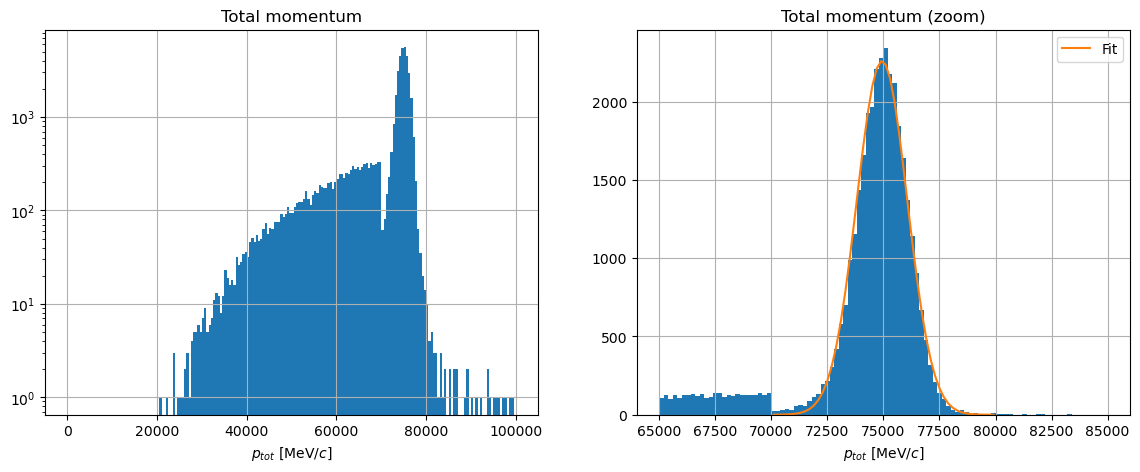

In [10]:
# Prepare two figures
fig, ax = plt.subplots(1,2, figsize=(14,5))

# Plot the total momentum in log scale
total_momentum = hlf.total_momentum(single_track_w_clusters)
total_momentum.hist(bins=200, range=(0, 100000), ax=ax[0])
ax[0].set_title("Total momentum")
ax[0].set_yscale("log")
ax[0].set_xlabel("$p_{tot}$ [MeV/$c$]")

# And perform a gaussian fit of the total momentum
fit_result = stats.perform_fit(total_momentum, bins=100, 
                               display_range=(65000, 85000), fit_range=(70000, 80000), 
                               ax=ax[1], model_wrapper=stats.gaussian_wrapper)
ax[1].set_title("Total momentum (zoom)")
ax[1].set_xlabel("$p_{tot}$ [MeV/$c$]")
print(fit_result.fit_report())

As can be seen above, the total momentum spreads from about 20 GeV up to 100 GeV. However we can observe a big peak at 75 GeV, which is the momentum of the initial kaon from the beam. Of all the single-track and two cluster decays that we are looking at, we can notice that only the k2pi is a closed decay (i.e. all decay products are observed, with no neutrino escaping the detector). In this case we expect that the total reconstructed momentum is indeed the same as the initial kaon. In the other cases, a part of the momentum is taken away by the neutrino. We can conclude that the big peak we see is due mostly to the contribution from the k2pi decay, with the remaining non-peaking contribution due to the kmu3 and ke3 decays. We can use this to try to separate k3pi from the two other decays.

Please note also that we performed a gaussian fit of the peaking contribution at 75 GeV, which resulted in a sigma of about 1.1 GeV. Below we are therefore separate our 1-track-2-clusters events into two categories:
 - closed kinematics: total momentum within 3 sigmas of 75 GeV
 - opened kinematics: total momentum outside 5 sigmas of 75 GeV (to make sure we reject all the k2pi in the peak)

#### Closed category

Average invariant mass: 492.83 MeV/c^2


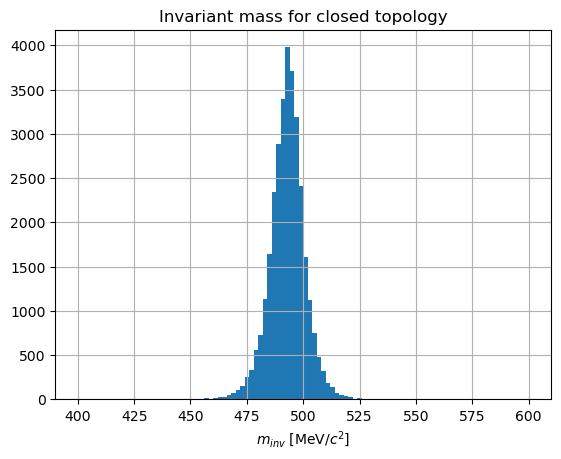

In [11]:
p_center = 75000
p_sigma = 1100
in_peak = (total_momentum>(p_center-3*p_sigma)) & (total_momentum<(p_center+3*p_sigma))
closed = single_track_w_clusters.loc[in_peak]
track1 = extract.track(closed, 1)
g2 = extract.photon_momentum(closed, 1)
g1 = extract.photon_momentum(closed, 2)
hlf.set_mass(track1, constants.pion_charged_mass)
hlf.set_mass(g1, constants.photon_mass)
hlf.set_mass(g2, constants.photon_mass)
inv_mass = hlf.invariant_mass([track1, g1, g2])
inv_mass.hist(bins=100, range=(400, 600))
plt.title("Invariant mass for closed topology")
plt.xlabel("$m_{inv}$ [MeV/$c^2$]")
print(f"Average invariant mass: {inv_mass.mean():.2f} MeV/c^2")

We have here a very clear sign of a k2pi decay: total reconstructed momentum similar to the beam momentum, and a peak in the invariant mass (assuming the track being a charged pion) at ~493 GeV which corresponds to the mass of the charged kaon.

Again, let's look at our two variables for this sample

In [12]:
# Print the fraction of events for each possible values of those variables
print(closed["event_type"].value_counts().sort_index()/len(closed))
all_tracks = extract.all_tracks(closed)
all_tracks = all_tracks.loc[(all_tracks["momentum_mag"]<40000) & (all_tracks["momentum_mag"]>15000)]
print(all_tracks["rich_hypothesis"].value_counts().sort_index()/len(all_tracks))

event_type
4    0.999341
6    0.000659
Name: count, dtype: float64
rich_hypothesis
0     0.000041
1     0.001117
2     0.051049
3     0.947752
99    0.000041
Name: count, dtype: float64


We can draw the following conclusions:
 - `event_type`: the value is dominated by '4' (almost 100%, from only 13% in the complete dataset), with a very small contribution from '6'. We can therefore conclude that `event_type==4 -> k2pi`
 - `rich_hypothesis`: the picture is even clearer than with the k3pi. We are very much dominated by the category '3' (94%) with small contribution from category '2' (which we now know are muons) and even smaller from the other categories. We strengthen our conclusion that `rich_hypothesis==3 -> charged pion`

We will conclude this study by separating the remaining contributions from k3pi and kmu3 in the "opened" sample.

In [13]:
# Select the "opened" sample = not 5sigma-closed
out_peak = ~((total_momentum>(p_center-5*p_sigma)) & (total_momentum<(p_center+5*p_sigma)))
opened = single_track_w_clusters.loc[out_peak]

However in this case computing the invariant mass will lead to similar result as for the total momentum: a continuous, non-peaking, distribution of event as the neutrino still takes away some of the energy. In the case of open decays, a better way is to look at the missing mass squared, which is computed as $m_\text{miss}^2 = p_\text{miss}^2 = (p_K - \sum{p_i})^2$ where $p_K$ is the beam 4-momentum and $p_i$ are the 4-momenta of the detected decay products. To have a better intuition looking at this variable, we can also look at the missing mass (square root of the missing mass squared) however with the additional complication that $m_\text{miss}^2$ can be negative. The square root for negative values is not well defined and results in complex number. Conventions could be to show then the absolute value (real part) of the mass (folding the negative part of the plot onto the positive part), or by convention to take the absolute value and keep the sign of the squared missing mass. This is the convention we are using in this code.

Only to prove the principle, we can first have a look at the missing mass squared for the k2pi decay where we consider only the charged track.

Median missing mass: 134.83 MeV/c^2


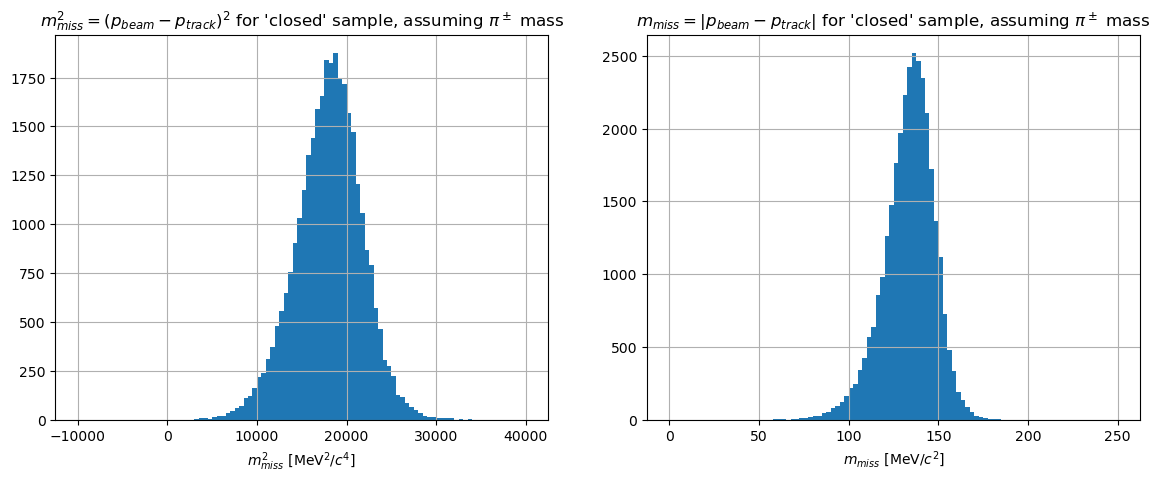

In [14]:
# Extract the beam momentum
beam = extract.get_beam(closed)
hlf.set_mass(beam, constants.kaon_charged_mass)

# Prepare two figures for missing mass squared and missing mass
fig, ax = plt.subplots(1,2, figsize=(14,5))

# Compute and plot
mmass_sq = hlf.missing_mass_sqr(beam, [track1])
mmass_sq.hist(bins=100, range=(-10000, 40000), ax=ax[0])
ax[0].set_xlabel("$m_{miss}^2$ [MeV$^2/c^4$]")
ax[0].set_title("$m_{miss}^2=(p_{beam}-p_{track})^2$ for 'closed' sample, assuming $\pi^\pm$ mass")
mmass = hlf.missing_mass(beam, [track1])
mmass.hist(bins=100, range=(0,250), ax=ax[1])
ax[1].set_xlabel("$m_{miss}$ [MeV$/c^2$]")
ax[1].set_title("$m_{miss}=|p_{beam}-p_{track}|$ for 'closed' sample, assuming $\pi^\pm$ mass")
print(f"Median missing mass: {mmass.median():.2f} MeV/c^2")

As you can see the missing mass peaks very neatly at ~134.8 MeV/$c^2$ which is very close to the $\pi^0$ mass (134.9768 MeV/$c^2$). Since the kaon decays into a $\pi^+$ and a $\pi^0$ and we neglect the $\pi^0$ in this missing mass computation, we expect to find exactly the $\pi^0$ mass.

On the other hand, if we do the same thing and choose a wrong mass for our track (let's assume it is a positron instead of a pion), this will look very different.

Median missing mass: 210.70 MeV/c^2


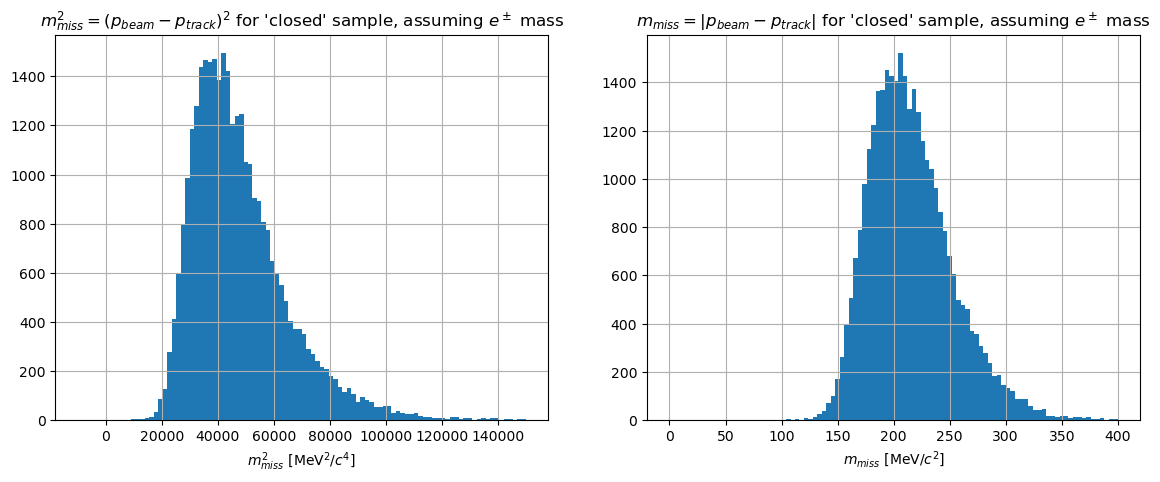

In [15]:
# Prepare two figures for missing mass squared and missing mass
fig, ax = plt.subplots(1,2, figsize=(14,5))

# Change the mass assumption for the track
hlf.set_mass(track1, constants.electron_mass)

# Compute and plot
mmass_sq = hlf.missing_mass_sqr(beam, [track1])
mmass_sq.hist(bins=100, range=(-10000, 150000), ax=ax[0])
ax[0].set_xlabel("$m_{miss}^2$ [MeV$^2/c^4$]")
ax[0].set_title("$m_{miss}^2=(p_{beam}-p_{track})^2$ for 'closed' sample, assuming $e^\pm$ mass")
mmass = hlf.missing_mass(beam, [track1])
mmass.hist(bins=100, range=(0,400), ax=ax[1])
ax[1].set_xlabel("$m_{miss}$ [MeV$/c^2$]")
ax[1].set_title("$m_{miss}=|p_{beam}-p_{track}|$ for 'closed' sample, assuming $e^\pm$ mass")
print(f"Median missing mass: {mmass.median():.2f} MeV/c^2")

As you can see, doing the wrong assumption we loose our nice peaking distribution and it is now much more spread. Also the maximum is now around ~210 MeV/$c^2$ which does not correspond to any particle. This proves that the technique is valid and provide a sort of "confirmation" of the mass assumption. It can also be used to separate samples with multiple decays (e.g. kmu3 and ke3) by making one assumption and selecting the peaking component. This is what we will do next.

#### Opened category
Let's go now to our "opened" sample and assume either the muon, or positron mass for the track, and taking into account the photons.

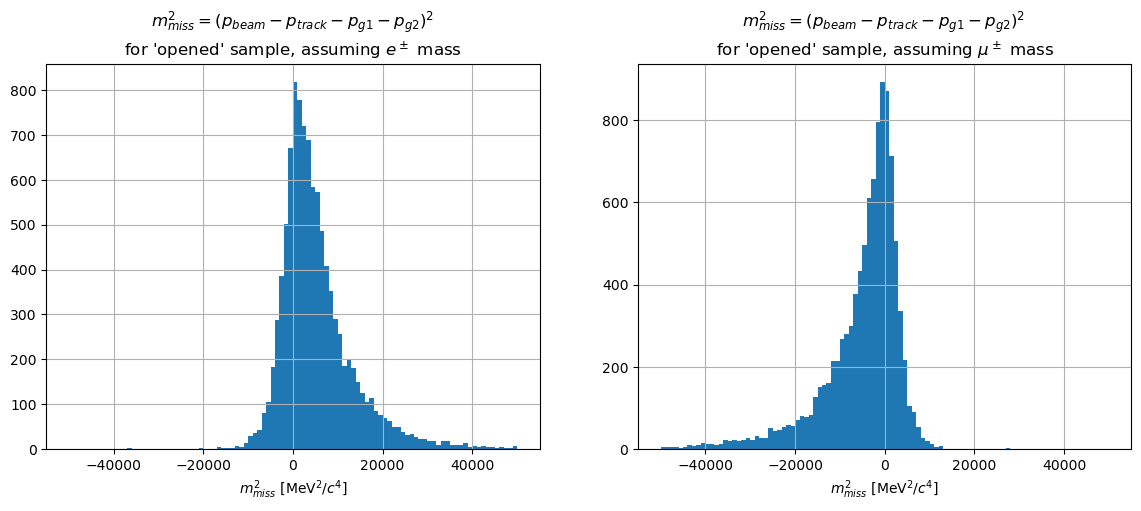

In [16]:
# Extract the beam momentum
beam = extract.get_beam(opened)
hlf.set_mass(beam, constants.kaon_charged_mass)

# Extract the tracks and photons
track1 = extract.track(opened, 1)
g2 = extract.photon_momentum(opened, 1)
g1 = extract.photon_momentum(opened, 2)
hlf.set_mass(g1, constants.photon_mass)
hlf.set_mass(g2, constants.photon_mass)

# Prepare two plots
fig, ax = plt.subplots(1,2, figsize=(14,5))

# Compute and plot the missing mass squared in the electron hypothesis
hlf.set_mass(track1, constants.electron_mass)
mmass_sqr_e = hlf.missing_mass_sqr(beam, [track1, g1, g2])
mmass_sqr_e.hist(bins=100, range=(-50000, 50000), ax=ax[0])
ax[0].set_xlabel("$m_{miss}^2$ [MeV$^2/c^4$]")
ax[0].set_title("$m_{miss}^2=(p_{beam}-p_{track} - p_{g1} - p_{g2})^2$ \nfor 'opened' sample, assuming $e^\pm$ mass")

# Compute and plot the missing mass squared in the muon hypothesis
hlf.set_mass(track1, constants.muon_mass)
mmass_sqr_mu = hlf.missing_mass_sqr(beam, [track1, g1, g2])
mmass_sqr_mu.hist(bins=100, range=(-50000, 50000), ax=ax[1])
ax[1].set_xlabel("$m_{miss}^2$ [MeV$^2/c^4$]")
_ = ax[1].set_title("$m_{miss}^2=(p_{beam}-p_{track} - p_{g1} - p_{g2})^2$ \nfor 'opened' sample, assuming $\mu^\pm$ mass")

We would expect to see a sharp peak at 0 for the events with the correct mass assumption and a wider distribution for the events with the wrong assumption. It appears however that the two distributions are not well resolved and pile-up on top of each other. We can nethertheless notice that for the positron assumption, the wide distribution is located only on the positive side of the $m_\text{miss}^2$, and inversely for the muon assumption. We can therefore still try to separate both by selecting only the events that are in each peak.

First let's find out a rough value for the resolution on $m_\text{miss}^2$ for $m_\text{miss}^2=0$. We can perform a gaussian fit with a strongly reduced range on the side of the extended distribution. This trick relies on the symmetry of a gaussian curve around it's mean, and the fact that we do not appear to have any contribution from the wrong mass assumption on one side of the peak. 
The peak resolution does not depend on the channel so we will get the same result from the ke3 or the kmu3 channel and we can choose whichever we want. Let's use the muon and fit in the range (-4000, 10000), which seems to visually contain the whole gaussian tail on the right, and just enough of the peak on the left to identify the mean.

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 14
    # variables        = 3
    chi-square         = 59.1036597
    reduced chi-square = 5.37305998
    Akaike info crit   = 26.1632972
    Bayesian info crit = 28.0804692
    R-squared          = 0.99995960
[[Variables]]
    amplitude:  6859509.43 +/- 270242.157 (3.94%) (init = 7857000)
    center:    -669.272839 +/- 175.699458 (26.25%) (init = -500)
    sigma:      3214.52561 +/- 134.216584 (4.18%) (init = 3000)
    fwhm:       7569.62908 +/- 316.055897 (4.18%) == '2.3548200*sigma'
    height:     851.307111 +/- 31.6842579 (3.72%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = -0.7164
    C(amplitude, center) = -0.5999
    C(amplitude, sigma)  = +0.5806


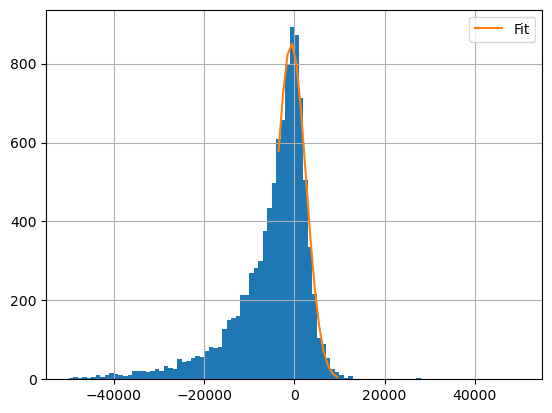

In [17]:
out = stats.perform_fit(mmass_sqr_mu, bins=100, display_range=(-50000, 50000), fit_range=(-4000, 10000), 
                        plot=True, model_wrapper=stats.gaussian_wrapper)
print(out.fit_report())

We obtain through this fit a resolution of approximately $\sigma_\text{mm2}=$3000 MeV$^2/c^4$. 

We will use this value to complete our selection:
 - For the ke3 selection, we select all events which are within $3\sigma_\text{mm2}$ of the peak in the positron hypothesis and outside of $5\sigma_\text{mm2}$ of the peak in the muon hypothesis
 - Inversey for the kmu3 selection, we select all events which are within $3\sigma_\text{mm2}$ of the peak in the muon hypothesis and outside of $5\sigma_\text{mm2}$ of the peak in the positron hypothesis

In this way we ensure that all events we select belong to only one of the category, at the price of a some loss of acceptance. But we do not care about acceptance at this point.

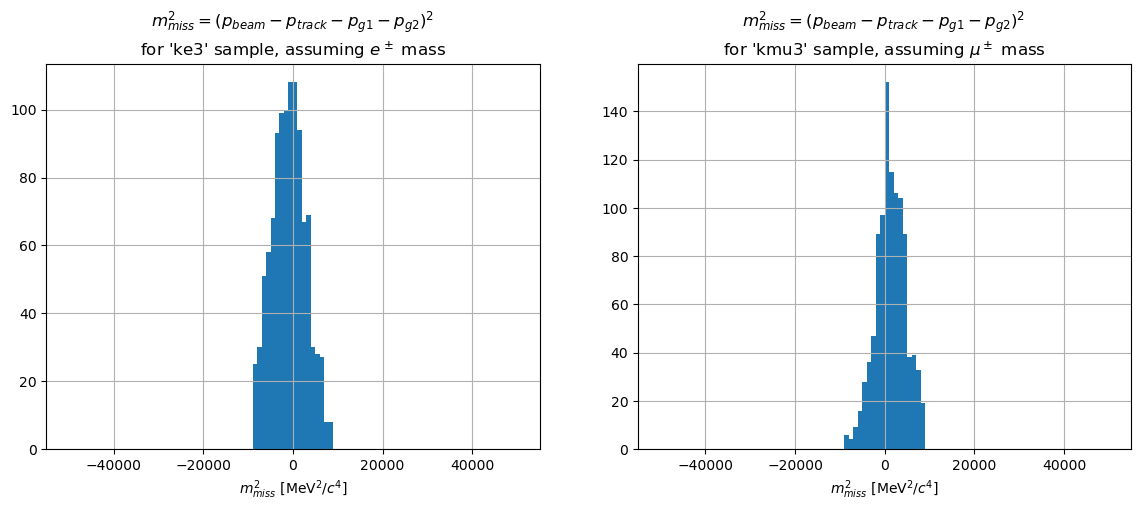

In [18]:
# Define the peak mean and sigma
mm2_mean = 0
mm2_sigma = 3000

# Define the "in_peak" and "out_peak" conditions
in_ke3_peak = (mmass_sqr_e<(mm2_mean+3*mm2_sigma)) & (mmass_sqr_e>(mm2_mean-3*mm2_sigma))
out_ke3_peak = (mmass_sqr_e>(mm2_mean+5*mm2_sigma)) | (mmass_sqr_e<(mm2_mean-5*mm2_sigma))
in_kmu3_peak = (mmass_sqr_mu<(mm2_mean+3*mm2_sigma)) & (mmass_sqr_mu>(mm2_mean-3*mm2_sigma))
out_kmu3_peak = (mmass_sqr_mu>(mm2_mean+5*mm2_sigma)) | (mmass_sqr_mu<(mm2_mean-5*mm2_sigma))

# Select our alleged ke3 and kmu3 events
ke3_events = opened.loc[in_ke3_peak & out_kmu3_peak]
kmu3_events = opened.loc[in_kmu3_peak & out_ke3_peak]

# Prepare two plots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot the missing mass squared for ke3 events in the positron mass hypothesis
beam = hlf.set_mass(extract.get_beam(ke3_events), constants.kaon_charged_mass)
track = hlf.set_mass(extract.track(ke3_events, 1), constants.electron_mass)
g1 = hlf.set_mass(extract.photon_momentum(ke3_events, 1), constants.photon_mass)
g2 = hlf.set_mass(extract.photon_momentum(ke3_events, 2), constants.photon_mass)
mmass_sqr_ke3 = hlf.missing_mass_sqr(beam, [track, g1, g2])
mmass_sqr_ke3.hist(bins=100, range=(-50000, 50000), ax=ax[0])
ax[0].set_xlabel("$m_{miss}^2$ [MeV$^2/c^4$]")
ax[0].set_title("$m_{miss}^2=(p_{beam}-p_{track} - p_{g1} - p_{g2})^2$ \nfor 'ke3' sample, assuming $e^\pm$ mass")

# Plot the missing mass squared for kmu3 events in the muon mass hypothesis
beam = hlf.set_mass(extract.get_beam(kmu3_events), constants.kaon_charged_mass)
track = hlf.set_mass(extract.track(kmu3_events, 1), constants.muon_mass)
g1 = hlf.set_mass(extract.photon_momentum(kmu3_events, 1), constants.photon_mass)
g2 = hlf.set_mass(extract.photon_momentum(kmu3_events, 2), constants.photon_mass)
mmass_sqr_kmu3 = hlf.missing_mass_sqr(beam, [track, g1, g2])
mmass_sqr_kmu3.hist(bins=100, range=(-50000, 50000), ax=ax[1])
ax[1].set_xlabel("$m_{miss}^2$ [MeV$^2/c^4$]")
_ = ax[1].set_title("$m_{miss}^2=(p_{beam}-p_{track} - p_{g1} - p_{g2})^2$ \nfor 'kmu3' sample, assuming $\mu^\pm$ mass")

After this final selection step, let's look at our two variables again, first for the kmu3 sample:

In [19]:
# Print the fraction of events for each possible values of those variables
print(kmu3_events["event_type"].value_counts().sort_index()/len(kmu3_events))
all_tracks = extract.all_tracks(kmu3_events)
all_tracks = all_tracks.loc[(all_tracks["momentum_mag"]<40000) & (all_tracks["momentum_mag"]>15000)]
print(all_tracks["rich_hypothesis"].value_counts().sort_index()/len(all_tracks))

event_type
2    0.002921
4    0.000974
5    0.995131
6    0.000974
Name: count, dtype: float64
rich_hypothesis
0    0.004246
1    0.004246
2    0.987261
3    0.004246
Name: count, dtype: float64


The picture is relatively clear:
 - `event_type`: the value is dominated by '5' (almost 100%, from only 2% in the complete dataset), with a very small contribution from other decays. We can therefore conclude that `event_type==5 -> kmu3`
 - `rich_hypothesis`: the category '2' is the major contribution (98%). This is consistent with our previous conclusions (twice already) that `rich_hypothesis==2 -> muon`

Doing the same for the ke3 sample:

In [20]:
# Print the fraction of events for each possible values of those variables
print(ke3_events["event_type"].value_counts().sort_index()/len(ke3_events))
all_tracks = extract.all_tracks(ke3_events)
all_tracks = all_tracks.loc[(all_tracks["momentum_mag"]<40000) & (all_tracks["momentum_mag"]>15000)]
print(all_tracks["rich_hypothesis"].value_counts().sort_index()/len(all_tracks))

event_type
2    0.994398
4    0.001867
5    0.003735
Name: count, dtype: float64
rich_hypothesis
0     0.002597
1     0.981818
2     0.007792
3     0.002597
99    0.005195
Name: count, dtype: float64


We have:
 - `event_type`: the value is dominated by '2' (almost 100%, from only 2% in the complete dataset), with a very small contribution from '5' (the kmu3). We can conclude that `event_type==2 -> ke3`
 - `rich_hypothesis`: the category '1' is 98% of the contribution with negligible contrubutions from the other categories. We conclude that `rich_hypothesis==1 -> electron/positron`

### Summary
We have used above only kinematic arguments to isolate samples of our five major kaon decay channels. We have not computed the acceptance (fraction of signal events selected with respect to number of signal events present in the sample) nor the purity (1-fraction of selected background events) of our sample, but we can assume that this kind of selection does not yield the best results as we are not exploiting all the capabilities of our detector. This was nevertheless good enough to have sufficiently clear samples which allowed us to draw conclusions on the `event_type` and `rich_hypothesis` variables.

Concerning the event_type, we have a total of six categories, but only five main decay channels. In fact the category '6' appears in all the samples we have isolated. We will consider this as unidentified background. In fact in the data that are made available for you, this category '6' are "autopass" events, meaning events that are randomly selected amongst those not belonging to any of the other categories.

For the `rich_hypothesis`, the dataset provided would not allow us to determine what are the meaning of the values '0', '4', and '99' and furthemore you will likely have no use for these categories in the rest of this exercise so they are given to you. A `rich_hypothesis` of '0' represent "background", i.e. some signal in the detector that is not necessarily related to any particle passing through the detector (e.g. electronic noise) or when we are not able to determine reliably another category (for example if the particle is outside the useful momentum range). A value of '4' indicates a particle that is identified as a $K^\pm$. In fact you can run the next cell to see that out of the few tracks that are present in the category '4' have mostly of momentum of 75 GeV/$c$, and probably correspond to beam kaon that are accidentaly associated to a vertex. Finally the category '99' correspond to signal where multiple tracks are on top of each other, rendering the identification impossible.

Let's summarize these conclusions:
 - `event_type`:
   - 1: $K^+\to\pi^+\pi^+\pi^-$ (k3pi)
   - 2: $K^+\to\pi^0 e^+\nu$ (ke3)
   - 3: $K^+\to\mu^+\nu$ (kmu2)
   - 4: $K^+\to\pi^+\pi^0$ (k2pi)
   - 5: $K^+\to\pi^0\mu^+\nu$ (kmu3)
   - 6: background (autopass)
 - `rich_hypothesis`:
   - 0: background
   - 1: $e^\pm$
   - 2: $\mu^\pm$
   - 3: $\pi^\pm$
   - 4: $K^\pm$
   - 99: Multiple